**PART 6: Large-Scale and Distributed Optimization**

Importing libraries

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import norm 
from sklearn.model_selection import train_test_split
from scipy.linalg import svdvals
from scipy.optimize import fmin_l_bfgs_b
from math import sqrt
from matplotlib.pyplot import figure
#figure(figsize=(10, 5), dpi=80)

Loading and cleaning the dataset

In [4]:
data=pd.read_csv('energy.csv')
data_copy=data.copy()
A = data_copy[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area','Overall_Height', 'Orientation', 'Glazing_Area','Glazing_Area_Distribution']]
y=data_copy[['Heating_Load']]

In [5]:
m=A.mean(axis=0)
s=A.std(axis=0)
my=y.mean()

A=(A-m)/s
y=y-my

n=A.shape[0]
d=A.shape[1]

A_mat=A.to_numpy()
y_mat=y.to_numpy().reshape(n)

Usefuls functions and classes (as seen during the practical sessions):


In [6]:
# Python class for regression problems
class RegPb(object):

    # Instantiate the class
    def __init__(self, A, y,lbda=0,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        self.lbda = lbda
        
    
    # Objective value
    def fun(self, x):
        if self.loss=='l2':
            return norm(self.A.dot(x) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            return np.mean(np.log(1. + np.exp(-yAx))) + self.lbda * norm(x) ** 2 / 2.
    
    # Partial objective value
    def f_i(self, i, x):
        if self.loss=='l2':
            return norm(self.A[i].dot(x) - self.y[i]) ** 2 / (2.) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAxi = self.y[i] * np.dot(self.A[i], x)
            return np.log(1. + np.exp(- yAxi)) + self.lbda * norm(x) ** 2 / 2.
    
    # Full gradient computation
    def grad(self, x):
        if self.loss=='l2':
            return self.A.T.dot(self.A.dot(x) - self.y) / self.n + self.lbda * x
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            aux = 1. / (1. + np.exp(yAx))
            return - (self.A.T).dot(self.y * aux) / self.n + self.lbda * x
    
    # Partial gradient
    def grad_i(self,i,x):
        a_i = self.A[i]
        if self.loss=='l2':
            return (a_i.dot(x) - self.y[i]) * a_i + self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* a_i.dot(x)))
            grad += self.lbda * x
            return grad

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n # More efficient than computing ||A^T A||
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

In [7]:
# Stochastic gradient implementation
def stoch_grad(x0,problem,xtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,average=0,scaling=0,with_replace=False,verbose=False): 

    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    d = problem.d
    
    # Initial value of current iterate  
    x = x0.copy()
    nx = norm(x)
    
    # Average (if needed)
    if average:
            xavg=np.zeros(len(x))
    
    #Scaling values
    if scaling>0:
        mu=1/(2 *(n ** (0.5)))
        v = np.zeros(d)
        beta = 0.8

    # Initialize iteration counter
    k=0
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    
    # Plot initial quantities of interest
    if verbose:
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],x)
            sg = sg + gi
        sg = (1/nb)*sg
        
        if scaling>0:
            if scaling==1:
                # RMSProp update
                v = beta*v + (1-beta)*sg*sg
            elif scaling==2:
                # Adagrad update
                v = v + sg*sg 
            sg = sg/(np.sqrt(v+mu))
            
        if stepchoice==0:
            x[:] = x - (1/L) * sg
        elif stepchoice==1:
            sk = float(step0/(sqrt(k+1)))
            x[:] = x - sk * sg
        
        nx = norm(x) #Computing the norm to measure divergence 
        
        if average:
            # If average, compute the average of the iterates
            xavg = k/(k+1) *xavg + x/(k+1) 
            nmin = norm(xavg-xtarget)
            obj = problem.fun(xavg)
        else:
            obj = problem.fun(x)
            nmin = norm(x-xtarget)
        
       
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))     
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    if average:
        x_output = xavg.copy()
    else:
        x_output = x.copy()
    return x_output, np.array(objvals), np.array(normits)

In [8]:
# Randomized coordinate descent
def rcd(x0,A,y,lbda,nblocks=1,nits=500): 
    """ 
        Inputs:
            x0: Initial point
            A: Data matrix
            y: Data vector
            lbda:: Regularization coefficient
            nblocks: Number of coordinates drawn at every iteration
            nits: Maximum number of iterations
            
        Outputs:
            x_output: Last iterate
            objvals: History of function values (Numpy array of length at most nits)
            nnzvals: History of iterate sparsity (Numpy array of length at most nits)
    """
    
    ############
    # Initialization
    objvals = []
    nnzvals = []
    
    # Initial iterate
    x = x0.copy()

    # Iteration index
    k=0    
    
    # Dimensions
    n,d = A.shape
    
    # Lipschitz constants
    ell = norm(A, ord=2) ** 2 / n + lbda
    # Initial objective value
    obj = norm(A.dot(x) - y,2) ** 2 / (2. * n)+ 0.5*lbda * norm(x,2)
    objvals.append(obj)
    # Number of nonzero coefficients
    nnzvals.append(np.count_nonzero(x))
    g = A.T.dot(A.dot(x) - y) / n + lbda*x
    #########################
    # Main Loop
    while (k < nits):
        jk = np.random.choice(d,nblocks,replace=False) # Uniform draw without replacement
        
        # Compute the new iterate by changing only one component
        for j in jk:
            x[j] = x[j]-(1/ell)*g[j]

        # Objective, sparsity level and gradient at the new point
        obj = norm(A.dot(x) - y) ** 2 / (2. * n)+ 0.5*lbda * norm(x,2)
        g = A.T.dot(A.dot(x) - y) / n + lbda*x
        objvals.append(obj)
        nnzvals.append(np.count_nonzero(x))
        k += 1  

    # End Main Loop  
    #######################
    
    x_output = x.copy()
          
    return x_output, np.array(objvals), np.array(nnzvals)

In [9]:
# Randomized coordinate descent
def rcd_sgd(x0,A,y,lbda,nb=1,nblocks=1,nits=500): 
    """ 
        Inputs:
            x0: Initial point
            A: Data matrix
            y: Data vector
            lbda:: Regularization coefficient
            nblocks: Number of coordinates drawn at every iteration
            nits: Maximum number of iterations
            
        Outputs:
            x_output: Last iterate
            objvals: History of function values (Numpy array of length at most nits)
            nnzvals: History of iterate sparsity (Numpy array of length at most nits)
    """
    
    ############
    # Initialization
    objvals = []
    nnzvals = []
    
    # Initial iterate
    x = x0.copy()

    # Iteration index
    k=0    
    
    # Dimensions
    n,p = A.shape
    
    # Lipschitz constants
    ell = norm(A, ord=2) ** 2 / n + lbda
    # Initial objective value
    obj = norm(A.dot(x) - y) ** 2 / (2. * n)+ 0.5*lbda * norm(x,2)
    objvals.append(obj)
    # Number of nonzero coefficients
    nnzvals.append(np.count_nonzero(x))
    ik = np.random.choice(n,nb,replace=False)# SGD
    sg = np.zeros(p)
    for j in ik:
      a_j= A[j]
      gi =  (a_j.dot(x) - y[j])*a_j + lbda*x
      sg = sg + gi
    sg = (1/nb)*sg
    #########################
    # Main Loop
    while (k < nits):
        jk = np.random.choice(p,nblocks,replace=False) # Uniform draw without replacement
        
        # Compute the new iterate by changing only one component
        sk = float(0.2/(sqrt(k+1)))
        for j in jk:
            x[j] = x[j]-sk*sg[j]
        # Objective, sparsity level and gradient at the new point
        obj = norm(A.dot(x) - y,2) ** 2 / (2. * n) + 0.5*lbda * norm(x,2)
        ik = np.random.choice(n,nb,replace=False)# SGD
        sg = np.zeros(p)
        for j in ik:
          a_j= A[j]
          gi = (a_j.dot(x) - y[j])*a_j + lbda*x
          sg = sg + gi
        sg = (1/nb)*sg
        #print("sg :",sg)
        if (k*nb) % n == 0:
          objvals.append(obj)
          nnzvals.append(np.count_nonzero(x))
        k += 1  
    # End Main Loop  
    #######################
    
    x_output = x.copy()
    return x_output, np.array(objvals), np.array(nnzvals)

In [10]:
#instantiating a regression problem, no ridge penalty
x_init = np.zeros(d)
lbda = 0
pblinreg = RegPb(A_mat, y_mat,lbda,loss='l2')

#Using L-BFGS-B algorithm to determine a solution

x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)

# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))

4.260264443454085
2.5196998677254253e-10


***Question 1:***

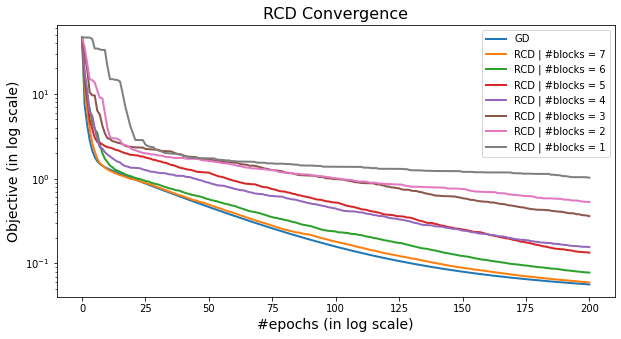

In [12]:
x_f, obj_f, nits_f = stoch_grad(x_init,pblinreg,x_min_lin,stepchoice=0,step0=1, n_iter=200,nb=n,verbose=False)
plt.figure(figsize=(10, 5))
plt.semilogy(obj_f-f_min_lin, label="GD", lw=2)
block_sizes = [7,6,5,4,3,2,1]
for nblockset in block_sizes:
  x_rcd, obj_rcd, nits_rcd = rcd(x_init,A_mat,y_mat,lbda=0,nblocks=nblockset,nits=200)
  plt.semilogy(obj_rcd-f_min_lin, label=f"RCD | #blocks = {nblockset}", lw=2)
#nb=int(n/11)
#x_rcd_sgd, obj_rcd_sgd, nits_rcd_sgd = rcd_sgd(x_init,A_matrix,y_matrix,lbda,nb,nblocks=nblockset,nits=2000*n/nblockset)
#plt.semilogy(obj_rcd_sgd-f_min_lin, label=f"RCD+SGD | batch size = {nb} ", lw=2)
plt.title("RCD Convergence", fontsize=16)
plt.xlabel("#epochs (in log scale)", fontsize=14)
plt.ylabel("Objective (in log scale)", fontsize=14)
plt.legend()

Using coordinate descente didn't outperform gradient descent here.

***Question 2:***

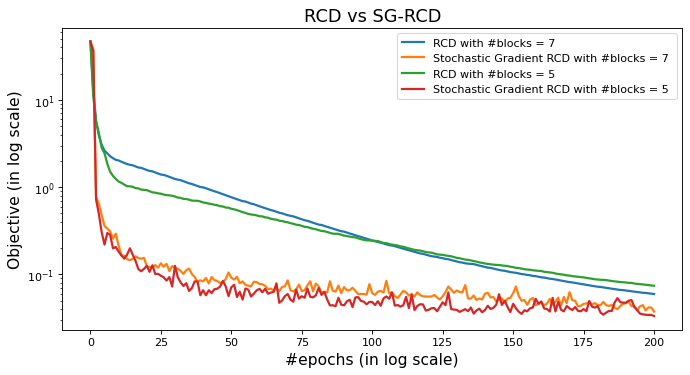

In [13]:
plt.figure(figsize=(10, 5),dpi=80)

vals_blockset = [7,5]
for nblockset in vals_blockset:
  x_rcd, obj_rcd, nits_rcd = rcd(x_init,A_mat,y_mat,lbda=0,nblocks=nblockset,nits=200)
  plt.semilogy(obj_rcd-f_min_lin, label=f"RCD with #blocks = {nblockset}", lw=2)
  x_rcd_sgd, obj_rcd_sgd, nits_rcd_sgd = rcd_sgd(x_init,A_mat,y_mat,lbda=0,nblocks=nblockset,nits=200*n)
  plt.semilogy(obj_rcd_sgd-f_min_lin, label=f"Stochastic Gradient RCD with #blocks = {nblockset} ", lw=2)
plt.title("RCD vs SG-RCD", fontsize=16)
plt.xlabel("#epochs (in log scale)", fontsize=14)
plt.ylabel("Objective (in log scale)", fontsize=14)
plt.legend()

RCD combined with stochastic gradient seems to converge faster. It outperforms the vanilla RCD.